# Importing Libraries

In [1]:
# Importing Necessary Libraries for Analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import geopandas as gpd
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import make_scorer
import xgboost as xgb
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

color = sns.color_palette()
%matplotlib inline

/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Importing Dataset

In [2]:
# Reading and Parsing Data Sets
dfTrain = pd.read_csv('train.csv', parse_dates=["timestamp"])
dfTest = pd.read_csv('test.csv', parse_dates=["timestamp"])

In [3]:
print (dfTrain.shape)
print (dfTrain.head())

(30471, 292)
   id  timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1 2011-08-20       43     27.0    4.0        NaN       NaN         NaN   
1   2 2011-08-23       34     19.0    3.0        NaN       NaN         NaN   
2   3 2011-08-27       43     29.0    2.0        NaN       NaN         NaN   
3   4 2011-09-01       89     50.0    9.0        NaN       NaN         NaN   
4   5 2011-09-05       77     77.0    4.0        NaN       NaN         NaN   

   num_room  kitch_sq    ...      cafe_count_5000_price_2500  \
0       NaN       NaN    ...                               9   
1       NaN       NaN    ...                              15   
2       NaN       NaN    ...                              10   
3       NaN       NaN    ...                              11   
4       NaN       NaN    ...                             319   

  cafe_count_5000_price_4000 cafe_count_5000_price_high  \
0                          4                          0   
1              

# Exploratory Analytics

## Log Price Distribution

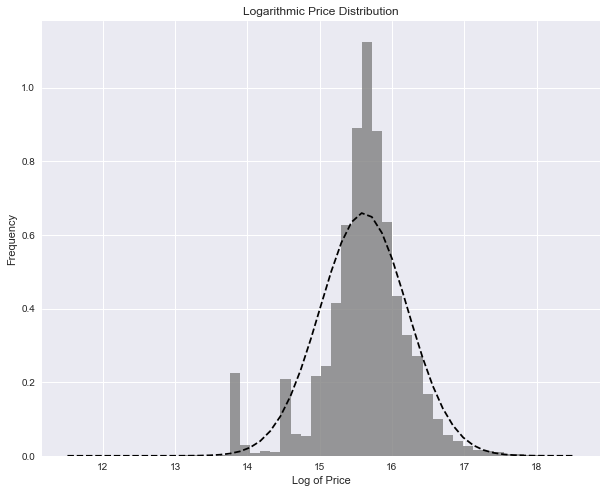

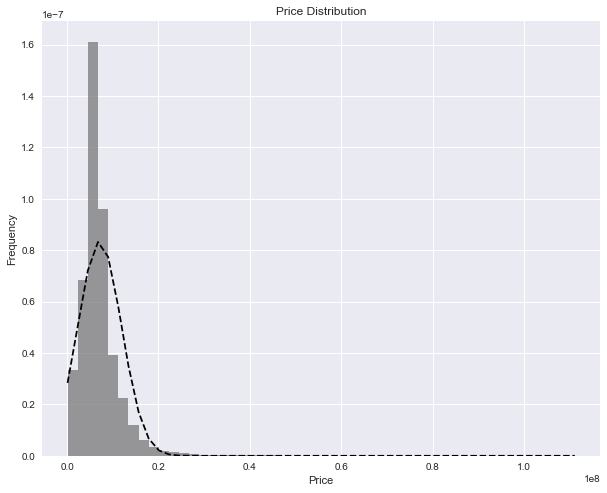

In [4]:
num_bins = 50
mu_log = np.mean(np.log(dfTrain['price_doc']))
sigma_log = np.std(np.log(dfTrain['price_doc']))

mu = np.mean(dfTrain['price_doc'])
sigma = np.std(dfTrain['price_doc'])

# Plotting Histogram of Logarithm of Price, as this will be evaluated by RSMLE
plt.figure(figsize=(10,8))
n, bins, patches = plt.hist(np.log(dfTrain['price_doc']), num_bins, facecolor='grey', alpha=0.8, normed=1)
plt.title("Logarithmic Price Distribution")
plt.xlabel("Log of Price")
plt.ylabel("Frequency")

y_log = mlab.normpdf(bins, mu_log, sigma_log)
plt.plot(bins, y_log, 'k--')

plt.figure(figsize=(10,8))
n, bins, patches = plt.hist(dfTrain['price_doc'], num_bins, facecolor='grey', alpha=0.8, normed=1)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")

y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'k--')

plt.show()

## Median House Price over Time

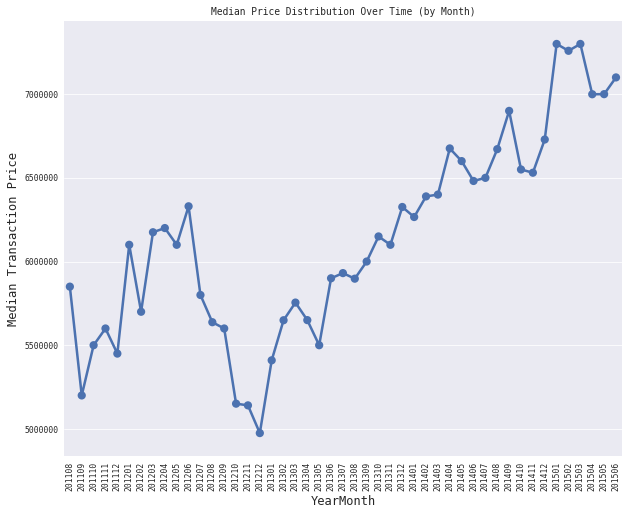

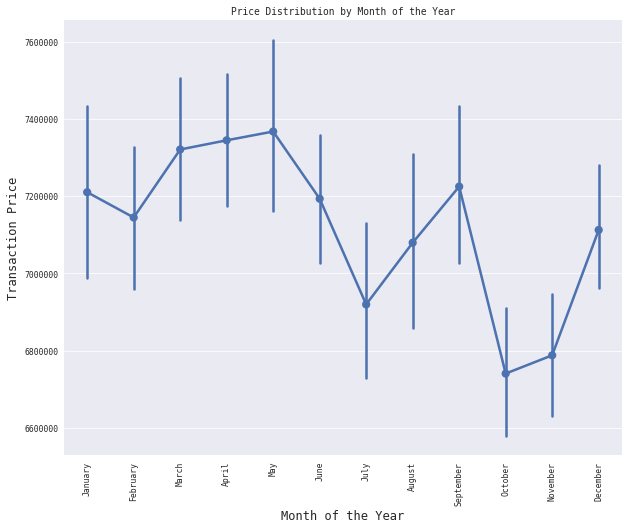

In [5]:
sns.set(context="paper", font="monospace")

# Median Price Distribution Over Time (by Month)
dfTrain["yearmonth"] = dfTrain["timestamp"].dt.year*100+dfTrain["timestamp"].dt.month
dfTrain["months"] = dfTrain["timestamp"].dt.month
dfGrouped_yearmonth = dfTrain.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

plt.figure()
plt.figure(figsize=(10,8))
sns.pointplot(x='yearmonth', y='price_doc', data=dfGrouped_yearmonth)
plt.ylabel('Median Transaction Price', fontsize=12)
plt.xlabel('YearMonth', fontsize=12)
plt.title('Median Price Distribution Over Time (by Month)')
plt.xticks(rotation='vertical')


# Median Price Distribution by Month of the Year
dfGrouped_month = dfTrain.groupby('months')['price_doc'].aggregate(np.median).reset_index()

plt.figure()
plt.figure(figsize=(10,8))

ax = sns.pointplot(x='months', y='price_doc', data=dfTrain)
plt.ylabel('Transaction Price', fontsize=12)
plt.xlabel('Month of the Year', fontsize=12)
plt.title('Price Distribution by Month of the Year')
plt.xticks(rotation='vertical')
ax.set(xticklabels=['January','February','March', 'April', 
                    'May', 'June', 'July', 'August', 'September',
                   'October', 'November', 'December'])
plt.show()

## Map Visualizations

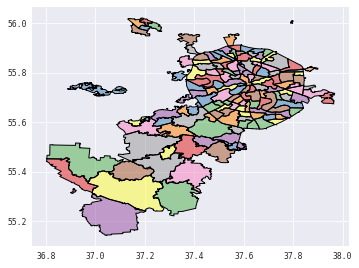

In [6]:
geo_df = gpd.read_file('mo_kag_SRHM.shp')
geo_df['geometry'].plot()

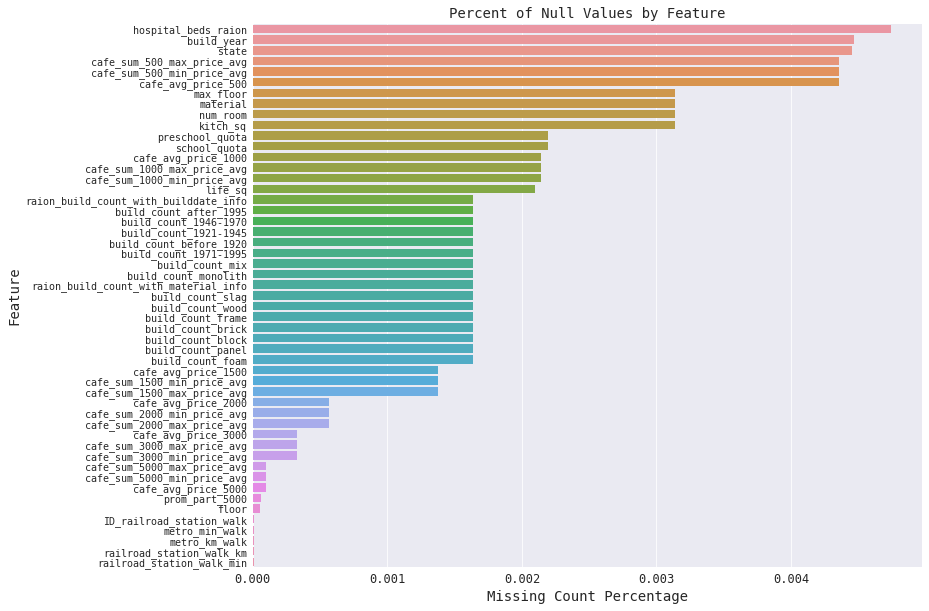

In [7]:
dfMissing = dfTrain.copy().isnull().sum(axis=0).reset_index()
dfMissing.columns = ['column_name', 'missing_count']
dfMissing = dfMissing[dfMissing.missing_count>0]
dfMissing['percent']=dfMissing['missing_count']/float(dfTrain.shape[0]*100)
plt.figure(figsize=(12,10))
sns.barplot(x='percent',y='column_name',data=dfMissing.sort_values("missing_count",ascending=False))
plt.title('Percent of Null Values by Feature',fontsize=14)
plt.xlabel('Missing Count Percentage',fontsize=14)
plt.ylabel('Feature',fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=12)
plt.show()

# Categorical Variable Conversion to Numerical Variables via Label Encoding

In [8]:
# Categorical Variable Conversion to Numerical Variables via Label Encoding
for a in dfTrain.columns:
    if dfTrain[a].dtype == 'object':
        print(a)
        label = preprocessing.LabelEncoder()
        label.fit(list(dfTrain[a].values.astype('str')) + list(dfTest[a].values.astype('str')))
        
        dfTrain[a]=label.transform(list(dfTrain[a].values.astype('str')))
        dfTest[a]=label.transform(list(dfTest[a].values.astype('str')))
        

product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology


# XGBoost

[0]	train-rmse:14.3687	test-rmse:14.3687
[50]	train-rmse:1.19521	test-rmse:1.21006
[100]	train-rmse:0.385651	test-rmse:0.473897
[150]	train-rmse:0.33928	test-rmse:0.46536


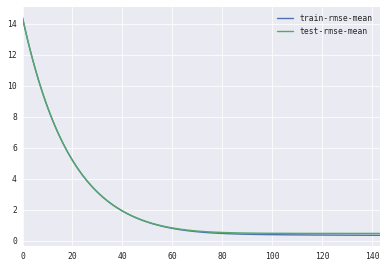

In [9]:
# Detecting Feature Importance using XGBoost
# First, remove "non-features"
# Separating Training and Target Features 
dfTrain_features = dfTrain.drop(['id', 'timestamp', 'months', 'yearmonth', 'price_doc'], axis = 1,inplace=False)
dfTrain_target = np.log(dfTrain.copy()['price_doc'])

# Perform a train-test split
xTrain,xTest,yTrain,yTest = model_selection.train_test_split(dfTrain_features, dfTrain_target, test_size=0.20, random_state=1)


# Setting Parameters
xgbParameters = {
    'max_depth': 8,
    'subsample' : 0.7,
    'objective' : 'reg:linear',
    'eval_metric' : 'rmse',
    'eta' : 0.05,
    'silent': 0,
    'colsample_bytree' : 0.7,
    'nthread' : 4
}

# Setting up XGBoost Booster
dataTrain = xgb.DMatrix (xTrain, yTrain, feature_names=xTrain.columns.values, silent=0)
dataTest = xgb.DMatrix (xTest, yTest, feature_names=xTest.columns.values, silent=0)

evallist  = [(dataTest,'eval'), (dataTrain,'train')]


xval_out = xgb.cv(xgbParameters,dataTrain,num_boost_round=500,nfold=5,
                  early_stopping_rounds=50,verbose_eval=50,show_stdv=False)
xval_out[['train-rmse-mean','test-rmse-mean']].plot()


## Feature Importance

[0]	eval-rmse:14.3581	train-rmse:14.3685
[1]	eval-rmse:13.6412	train-rmse:13.6514
[2]	eval-rmse:12.9603	train-rmse:12.9701
[3]	eval-rmse:12.3132	train-rmse:12.323
[4]	eval-rmse:11.6984	train-rmse:11.7081
[5]	eval-rmse:11.1144	train-rmse:11.1242
[6]	eval-rmse:10.5598	train-rmse:10.5694
[7]	eval-rmse:10.0331	train-rmse:10.0424
[8]	eval-rmse:9.53237	train-rmse:9.54169
[9]	eval-rmse:9.05682	train-rmse:9.0661
[10]	eval-rmse:8.60503	train-rmse:8.61433
[11]	eval-rmse:8.17612	train-rmse:8.18527
[12]	eval-rmse:7.76849	train-rmse:7.77756
[13]	eval-rmse:7.38173	train-rmse:7.39055
[14]	eval-rmse:7.01417	train-rmse:7.02293
[15]	eval-rmse:6.66515	train-rmse:6.67371
[16]	eval-rmse:6.33371	train-rmse:6.3421
[17]	eval-rmse:6.01873	train-rmse:6.02713
[18]	eval-rmse:5.71977	train-rmse:5.72804
[19]	eval-rmse:5.43593	train-rmse:5.44405
[20]	eval-rmse:5.16633	train-rmse:5.1743
[21]	eval-rmse:4.91018	train-rmse:4.91808
[22]	eval-rmse:4.66696	train-rmse:4.67473
[23]	eval-rmse:4.43613	train-rmse:4.44372
[24]	e

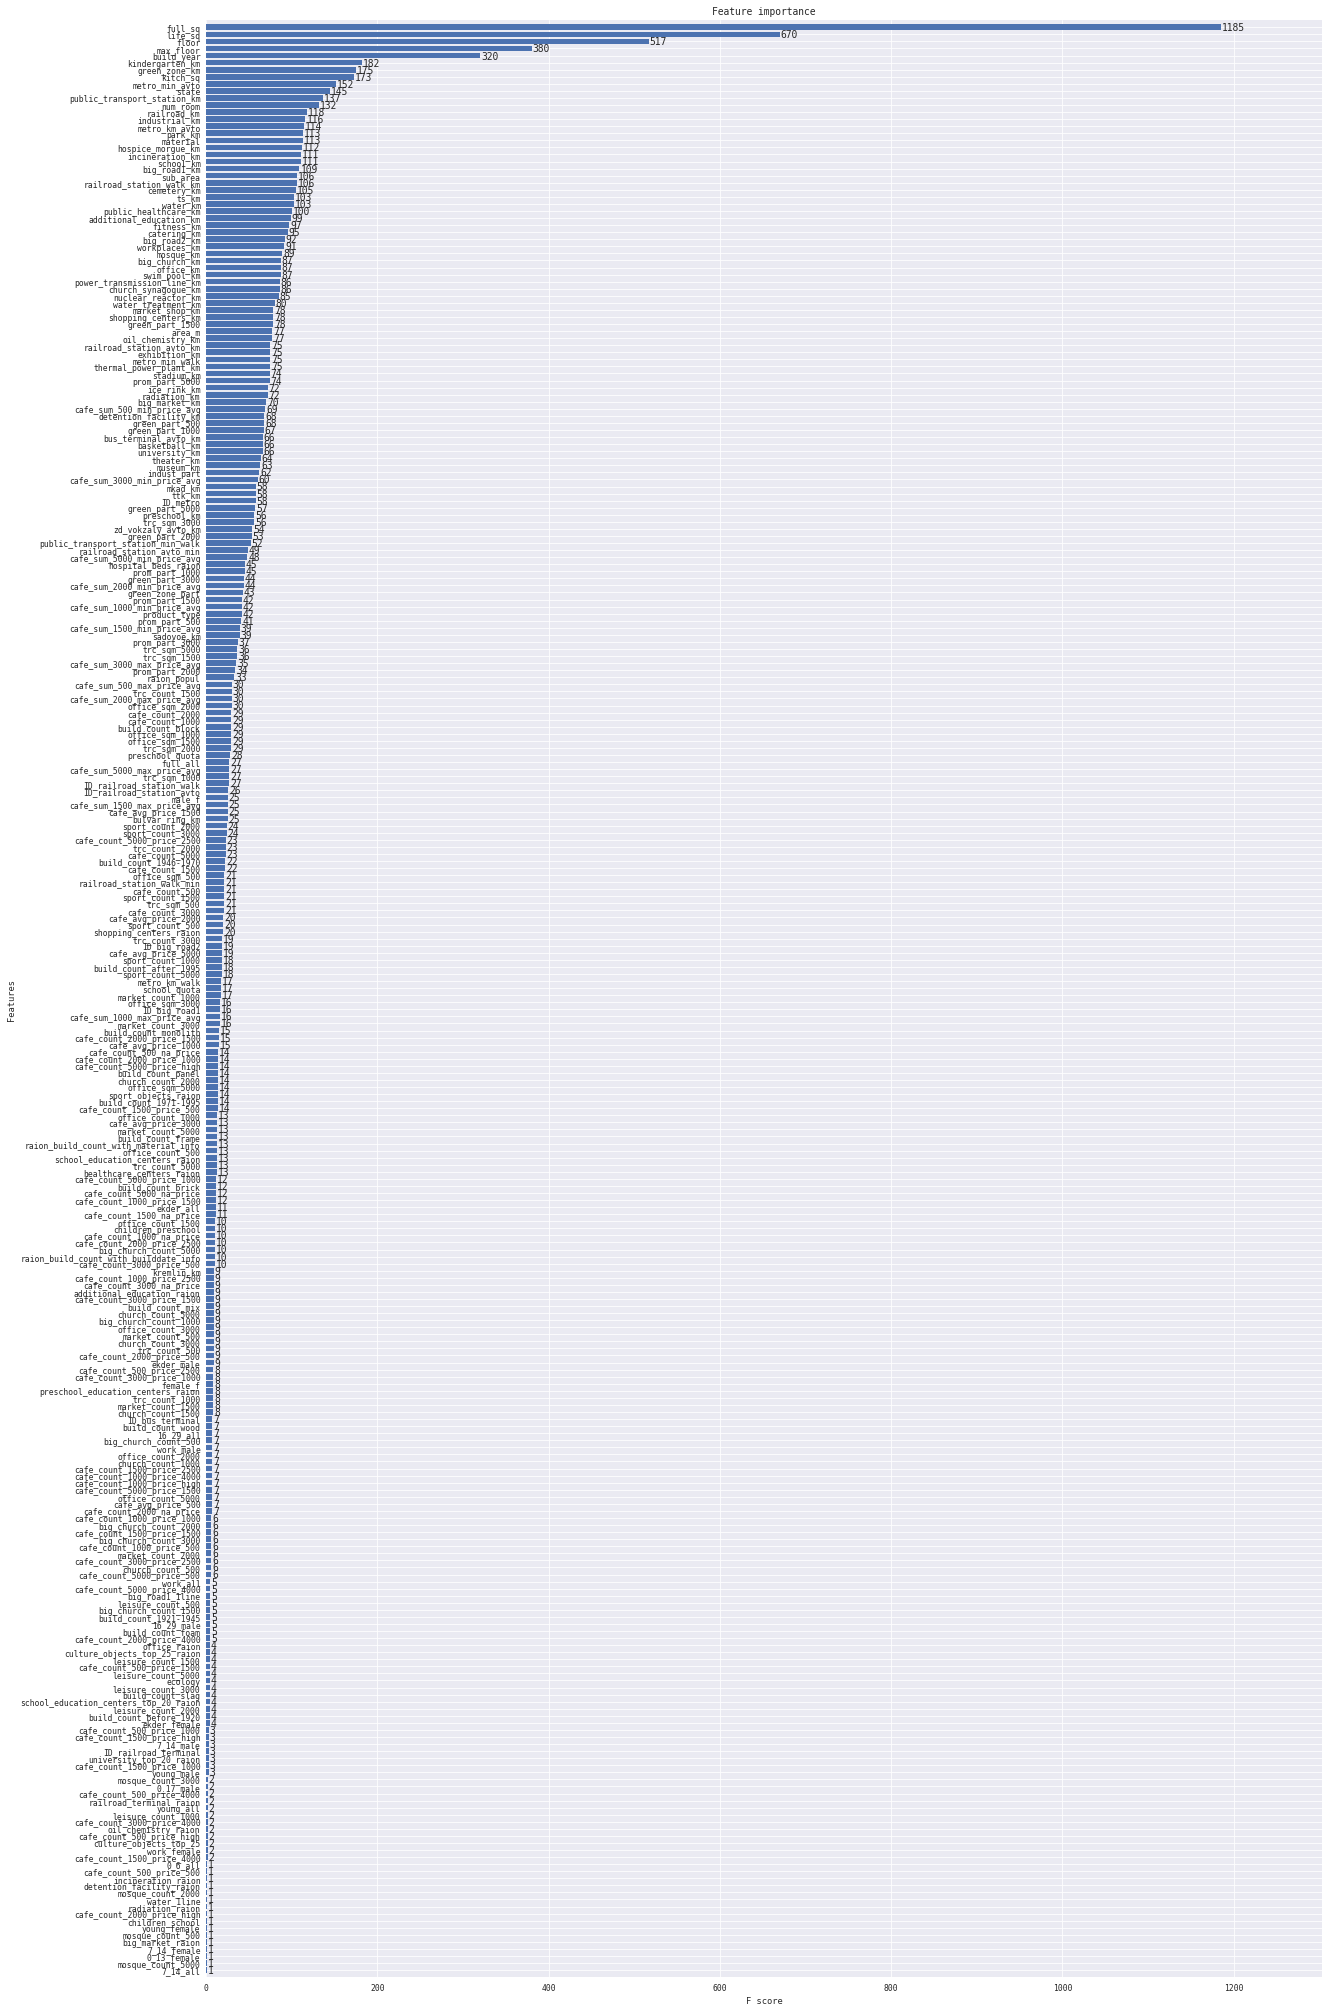

In [10]:
dataModel = xgb.train(xgbParameters, dataTrain, num_boost_round=len(xval_out), evals=evallist)

# Plotting Feature Importance
fig, ax = plt.subplots(figsize=(20,36))
xgb.plot_importance(dataModel, height=0.8, ax=ax)
plt.show()

## Correlation Matrix

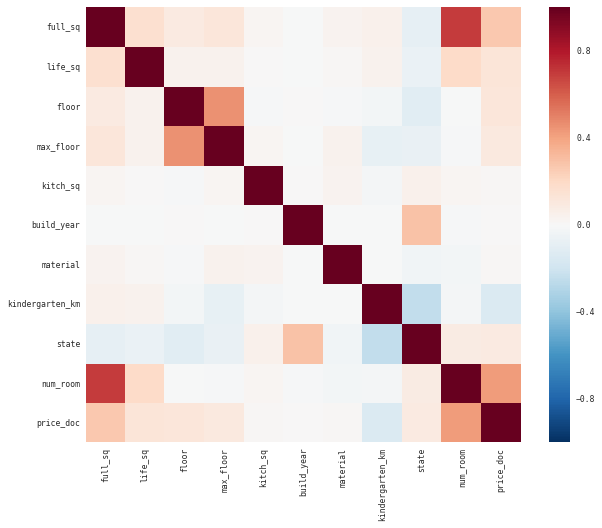

In [11]:
# Generating correlation matrix
dfTrain_feats_target = pd.concat([dfTrain_features,dfTrain_target],axis=1,ignore_index=False)
corrmat = dfTrain_feats_target.corr()

# Top ten features based on Fscores from XGBoost
topTen = corrmat.loc[["full_sq", "life_sq", "floor", "max_floor", "kitch_sq", "build_year",
                "material", "kindergarten_km", "state",
                "num_room", "price_doc"],["full_sq", "life_sq", "floor", "max_floor", "kitch_sq", "build_year",
                "material", "kindergarten_km", "state",
                "num_room", "price_doc"]]

# Setting up the matplotlib figure
f, ax = plt.subplots(figsize=(10,8))

# Drawing the heatmap
sns.heatmap(topTen, square=True)

## New Variable Creation (Ratios)

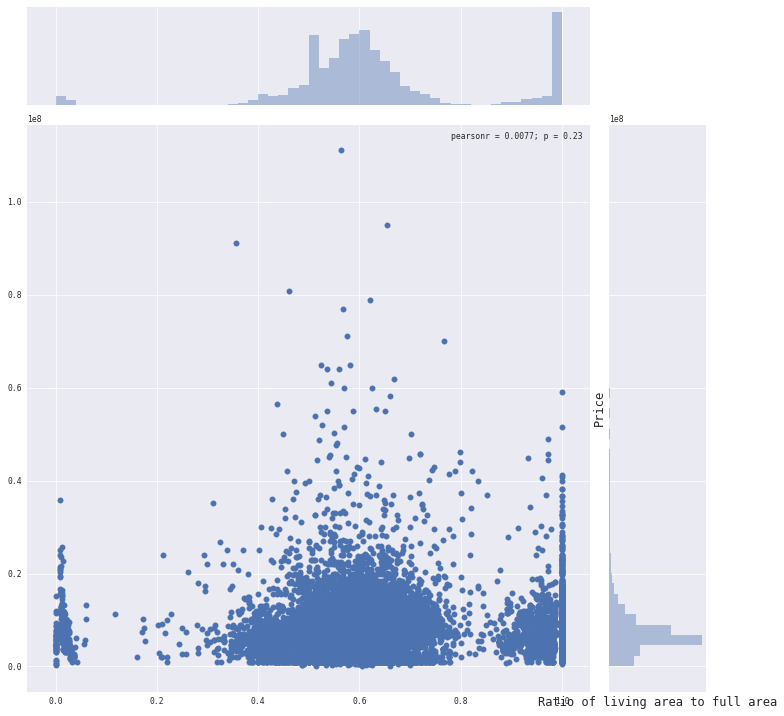

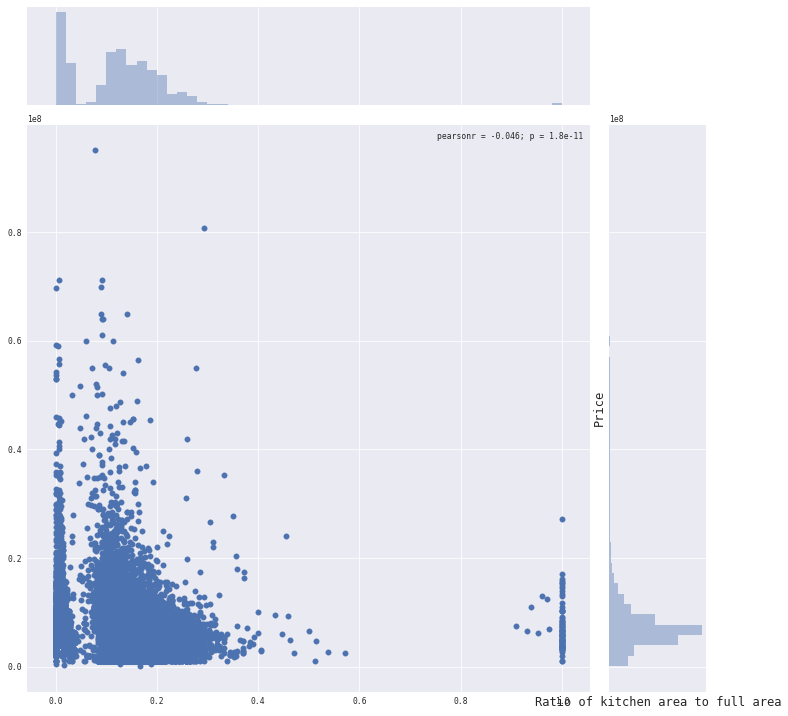

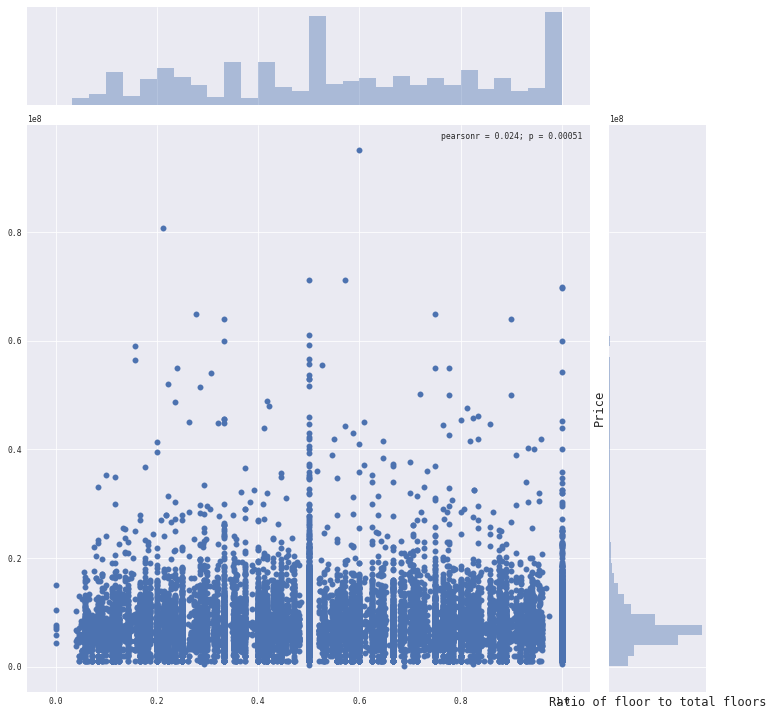

In [12]:
# Generating ratios

dfTrain['life_full_ratio'] = dfTrain.copy()['life_sq']/np.maximum(dfTrain.copy()['full_sq'].astype('float'),1)
dfTrain.loc[dfTrain.life_full_ratio<0,'life_full_ratio']=0
dfTrain.loc[dfTrain.life_full_ratio>1,'life_full_ratio']=1

dfTrain['kitch_full_ratio'] = dfTrain.copy()['kitch_sq']/np.maximum(dfTrain.copy()['full_sq'].astype('float'),1)
dfTrain.loc[dfTrain.kitch_full_ratio<0,'kitch_full_ratio']=0
dfTrain.loc[dfTrain.kitch_full_ratio>1,'kitch_full_ratio']=1

dfTrain['height_ratio'] = dfTrain.copy()['floor']/np.maximum(dfTrain.copy()['max_floor'].astype('float'),1)
dfTrain.loc[dfTrain.height_ratio<0,'height_ratio']=0.5
dfTrain.loc[dfTrain.height_ratio>1,'height_ratio']=0.5


# Plots

plt.figure()
plt.figure(figsize=(10,8))
sns.jointplot(x=dfTrain.life_full_ratio.values,y=(dfTrain.price_doc.values),size=10)
plt.ylabel('Price',fontsize=12)
plt.xlabel('Ratio of living area to full area', fontsize=12)

plt.figure()
plt.figure(figsize=(10,8))
sns.jointplot(x=dfTrain.kitch_full_ratio.values,y=(dfTrain.price_doc.values),size=10)
plt.ylabel('Price',fontsize=12)
plt.xlabel('Ratio of kitchen area to full area', fontsize=12)

plt.figure()
plt.figure(figsize=(10,8))
sns.jointplot(x=dfTrain.height_ratio.values,y=(dfTrain.price_doc.values),size=10)
plt.ylabel('Price',fontsize=12)
plt.xlabel('Ratio of floor to total floors', fontsize=12)


## Model Building

In [13]:
def RMSLE_Score(actual, predicted):
    rmsle=np.sqrt(np.mean(np.power(np.log(predicted+1)-np.log(actual+1),2)))
    return rmsle

## Lasso Model

In [14]:
# Filling Null values
dfTrain.fillna(-99, inplace = True)

# Perform a train-test split
dfTrain_features = dfTrain.copy()[["full_sq", "life_sq", "floor", "max_floor", "kitch_sq", "num_room",
                "material", "state", "kitch_full_ratio", "life_full_ratio"]]
dfTrain_target = np.log(dfTrain.copy()['price_doc'])
xTrain,xTest,yTrain,yTest = model_selection.train_test_split(dfTrain_features, dfTrain_target, test_size=0.3, random_state=1)

lasso = Lasso(random_state=1)
params = {'alpha': np.linspace(0.1,1,10)}

rmsle = make_scorer(RMSLE_Score, greater_is_better=False)

print("Scorer Instantiated. Running Grid Search Cross-Validation")                                                             

grid = model_selection.GridSearchCV(estimator=lasso, 
                    param_grid=params, 
                    cv=10,
                    refit=True, verbose=10,
                    scoring=rmsle)

print("Grid created. Running fit on xTrain,yTrain")
grid.fit(xTrain, yTrain)
print("Done Fitting")

print(RMSLE_Score(yTest,grid.predict(xTest)))


Scorer Instantiated. Running Grid Search Cross-Validation
Grid created. Running fit on xTrain,yTrain
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] alpha=0.1 .......................................................
[CV] ....................... alpha=0.1, score=-0.034724, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ....................... alpha=0.1, score=-0.033962, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ....................... alpha=0.1, score=-0.034441, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ....................... alpha=0.1, score=-0.046639, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ....................... alpha=0.1, score=-0.035702, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ....................... alpha=0.1, score=-0.046926

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV] ....................... alpha=0.2, score=-0.034739, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.034004, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.034480, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.045442, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.035739, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.046760, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.033822, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] .

[CV] ....................... alpha=0.8, score=-0.035974, total=   0.0s
[CV] alpha=0.8 .......................................................
[CV] ....................... alpha=0.8, score=-0.045587, total=   0.0s
[CV] alpha=0.8 .......................................................
[CV] ....................... alpha=0.8, score=-0.034025, total=   0.0s
[CV] alpha=0.8 .......................................................
[CV] ....................... alpha=0.8, score=-0.034142, total=   0.0s
[CV] alpha=0.8 .......................................................
[CV] ....................... alpha=0.8, score=-0.034152, total=   0.0s
[CV] alpha=0.8 .......................................................
[CV] ....................... alpha=0.8, score=-0.034020, total=   0.0s
[CV] alpha=0.9 .......................................................
[CV] ....................... alpha=0.9, score=-0.034945, total=   0.0s
[CV] alpha=0.9 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished


In [15]:
print(grid.best_estimator_)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)


## Elastic Net

In [16]:
elNet = ElasticNet(random_state=1)
params_elNet = {'alpha': np.linspace(0.1,10,10),
          'l1_ratio':np.linspace(0.1,0.5,5)}

grid_elNet = model_selection.GridSearchCV(estimator=elNet, 
                    param_grid=params_elNet, 
                    cv=10,
                    refit=True, verbose=10,
                    scoring=rmsle)

print("Grid created. Running fit on xTrain,yTrain")
grid_elNet.fit(xTrain, yTrain)
print("Done Fitting")

print(RMSLE_Score(yTest,grid_elNet.predict(xTest)))


Grid created. Running fit on xTrain,yTrain
Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] alpha=0.1, l1_ratio=0.1 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ......... alpha=0.1, l1_ratio=0.1, score=-0.034448, total=   0.5s
[CV] alpha=0.1, l1_ratio=0.1 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] ......... alpha=0.1, l1_ratio=0.1, score=-0.033626, total=   0.6s
[CV] alpha=0.1, l1_ratio=0.1 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s


[CV] ......... alpha=0.1, l1_ratio=0.1, score=-0.034122, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.1 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s


[CV] ......... alpha=0.1, l1_ratio=0.1, score=-0.047065, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.1 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s


[CV] ......... alpha=0.1, l1_ratio=0.1, score=-0.035421, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.1 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.7s remaining:    0.0s


[CV] ......... alpha=0.1, l1_ratio=0.1, score=-0.046913, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.1 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.2s remaining:    0.0s


[CV] ......... alpha=0.1, l1_ratio=0.1, score=-0.033420, total=   0.5s
[CV] alpha=0.1, l1_ratio=0.1 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.5s remaining:    0.0s


[CV] ......... alpha=0.1, l1_ratio=0.1, score=-0.033535, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.1 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.9s remaining:    0.0s


[CV] ......... alpha=0.1, l1_ratio=0.1, score=-0.033591, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.1 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.1, score=-0.033394, total=   0.5s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.2, score=-0.034487, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.2, score=-0.033673, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.2, score=-0.034168, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.2, score=-0.047130, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.2, score=-0.035458, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.2, score=-0.047010, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.2, score=-0.033480, total=   0.5s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.2, score=-0.033568, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.2, score=-0.033627, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.2 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.2, score=-0.033437, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.3 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.3, score=-0.034534, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.3 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.3, score=-0.033730, total=   0.3s
[CV] alpha=0.1, l1_ratio=0.3 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.3, score=-0.034222, total=   0.3s
[CV] alpha=0.1, l1_ratio=0.3 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.3, score=-0.047202, total=   0.3s
[CV] alpha=0.1, l1_ratio=0.3 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.3, score=-0.035506, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.3 .........................................
[CV] ......... alpha=0.1, l1_ratio=0.3, score=-0.047036, total=   0.1s
[CV] alpha=0.1, l1_ratio=0.3 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.3, score=-0.033551, total=   0.3s
[CV] alpha=0.1, l1_ratio=0.3 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.3, score=-0.033611, total=   0.3s
[CV] alpha=0.1, l1_ratio=0.3 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.3, score=-0.033672, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.3 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.3, score=-0.033490, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.4, score=-0.034590, total=   0.3s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.4, score=-0.033797, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.4, score=-0.034286, total=   0.5s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.4, score=-0.047263, total=   0.7s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.4, score=-0.035563, total=   0.5s
[CV] alpha=0.1, l1_ratio=0.4 .........................................
[CV] ......... alpha=0.1, l1_ratio=0.4, score=-0.047023, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.4, score=-0.033634, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.4, score=-0.033664, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.4, score=-0.033725, total=   0.3s
[CV] alpha=0.1, l1_ratio=0.4 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.4, score=-0.033552, total=   0.5s
[CV] alpha=0.1, l1_ratio=0.5 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.5, score=-0.034656, total=   0.5s
[CV] alpha=0.1, l1_ratio=0.5 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.5, score=-0.033875, total=   0.3s
[CV] alpha=0.1, l1_ratio=0.5 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.5, score=-0.034359, total=   0.3s
[CV] alpha=0.1, l1_ratio=0.5 .........................................
[CV] ......... alpha=0.1, l1_ratio=0.5, score=-0.047207, total=   0.1s
[CV] alpha=0.1, l1_ratio=0.5 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.5, score=-0.035629, total=   0.3s
[CV] alpha=0.1, l1_ratio=0.5 .........................................
[CV] ......... alpha=0.1, l1_ratio=0.5, score=-0.047007, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.5 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.5, score=-0.033728, total=   0.4s
[CV] alpha=0.1, l1_ratio=0.5 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.5, score=-0.033726, total=   0.6s
[CV] alpha=0.1, l1_ratio=0.5 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.5, score=-0.033787, total=   1.0s
[CV] alpha=0.1, l1_ratio=0.5 .........................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ......... alpha=0.1, l1_ratio=0.5, score=-0.033622, total=   0.3s
[CV] alpha=1.2, l1_ratio=0.1 .........................................
[CV] ......... alpha=1.2, l1_ratio=0.1, score=-0.034726, total=   0.0s
[CV] alpha=1.2, l1_ratio=0.1 .........................................
[CV] ......... alpha=1.2, l1_ratio=0.1, score=-0.033971, total=   0.0s
[CV] alpha=1.2, l1_ratio=0.1 .........................................
[CV] ......... alpha=1.2, l1_ratio=0.1, score=-0.034449, total=   0.0s
[CV] alpha=1.2, l1_ratio=0.1 .........................................
[CV] ......... alpha=1.2, l1_ratio=0.1, score=-0.046287, total=   0.0s
[CV] alpha=1.2, l1_ratio=0.1 .........................................
[CV] ......... alpha=1.2, l1_ratio=0.1, score=-0.035709, total=   0.0s
[CV] alpha=1.2, l1_ratio=0.1 .........................................
[CV] ......... alpha=1.2, l1_ratio=0.1, score=-0.046869, total=   0.0s
[CV] alpha=1.2, l1_ratio=0.1 .........................................
[CV] .

[CV] ......... alpha=2.3, l1_ratio=0.2, score=-0.041969, total=   0.0s
[CV] alpha=2.3, l1_ratio=0.2 .........................................
[CV] ......... alpha=2.3, l1_ratio=0.2, score=-0.035872, total=   0.0s
[CV] alpha=2.3, l1_ratio=0.2 .........................................
[CV] ......... alpha=2.3, l1_ratio=0.2, score=-0.046245, total=   0.0s
[CV] alpha=2.3, l1_ratio=0.2 .........................................
[CV] ......... alpha=2.3, l1_ratio=0.2, score=-0.033926, total=   0.0s
[CV] alpha=2.3, l1_ratio=0.2 .........................................
[CV] ......... alpha=2.3, l1_ratio=0.2, score=-0.034055, total=   0.0s
[CV] alpha=2.3, l1_ratio=0.2 .........................................
[CV] ......... alpha=2.3, l1_ratio=0.2, score=-0.034050, total=   0.0s
[CV] alpha=2.3, l1_ratio=0.2 .........................................
[CV] ......... alpha=2.3, l1_ratio=0.2, score=-0.033905, total=   0.0s
[CV] alpha=2.3, l1_ratio=0.3 .........................................
[CV] .

[CV] ......... alpha=3.4, l1_ratio=0.3, score=-0.045096, total=   0.0s
[CV] alpha=3.4, l1_ratio=0.3 .........................................
[CV] ......... alpha=3.4, l1_ratio=0.3, score=-0.034095, total=   0.0s
[CV] alpha=3.4, l1_ratio=0.3 .........................................
[CV] ......... alpha=3.4, l1_ratio=0.3, score=-0.034204, total=   0.0s
[CV] alpha=3.4, l1_ratio=0.3 .........................................
[CV] ......... alpha=3.4, l1_ratio=0.3, score=-0.034224, total=   0.0s
[CV] alpha=3.4, l1_ratio=0.3 .........................................
[CV] ......... alpha=3.4, l1_ratio=0.3, score=-0.034101, total=   0.0s
[CV] alpha=3.4, l1_ratio=0.4 .........................................
[CV] ......... alpha=3.4, l1_ratio=0.4, score=-0.035083, total=   0.0s
[CV] alpha=3.4, l1_ratio=0.4 .........................................
[CV] ......... alpha=3.4, l1_ratio=0.4, score=-0.034374, total=   0.0s
[CV] alpha=3.4, l1_ratio=0.4 .........................................
[CV] .

[CV] ......... alpha=5.6, l1_ratio=0.1, score=-0.034856, total=   0.0s
[CV] alpha=5.6, l1_ratio=0.1 .........................................
[CV] ......... alpha=5.6, l1_ratio=0.1, score=-0.034156, total=   0.0s
[CV] alpha=5.6, l1_ratio=0.1 .........................................
[CV] ......... alpha=5.6, l1_ratio=0.1, score=-0.034637, total=   0.0s
[CV] alpha=5.6, l1_ratio=0.1 .........................................
[CV] ......... alpha=5.6, l1_ratio=0.1, score=-0.040399, total=   0.0s
[CV] alpha=5.6, l1_ratio=0.1 .........................................
[CV] ......... alpha=5.6, l1_ratio=0.1, score=-0.035904, total=   0.0s
[CV] alpha=5.6, l1_ratio=0.1 .........................................
[CV] ......... alpha=5.6, l1_ratio=0.1, score=-0.045978, total=   0.0s
[CV] alpha=5.6, l1_ratio=0.1 .........................................
[CV] ......... alpha=5.6, l1_ratio=0.1, score=-0.033957, total=   0.0s
[CV] alpha=5.6, l1_ratio=0.1 .........................................
[CV] .

[CV] ......... alpha=6.7, l1_ratio=0.2, score=-0.034370, total=   0.0s
[CV] alpha=6.7, l1_ratio=0.2 .........................................
[CV] ......... alpha=6.7, l1_ratio=0.2, score=-0.034849, total=   0.0s
[CV] alpha=6.7, l1_ratio=0.2 .........................................
[CV] ......... alpha=6.7, l1_ratio=0.2, score=-0.035656, total=   0.0s
[CV] alpha=6.7, l1_ratio=0.2 .........................................
[CV] ......... alpha=6.7, l1_ratio=0.2, score=-0.036158, total=   0.0s
[CV] alpha=6.7, l1_ratio=0.2 .........................................
[CV] ......... alpha=6.7, l1_ratio=0.2, score=-0.044446, total=   0.0s
[CV] alpha=6.7, l1_ratio=0.2 .........................................
[CV] ......... alpha=6.7, l1_ratio=0.2, score=-0.034202, total=   0.0s
[CV] alpha=6.7, l1_ratio=0.2 .........................................
[CV] ......... alpha=6.7, l1_ratio=0.2, score=-0.034300, total=   0.0s
[CV] alpha=6.7, l1_ratio=0.2 .........................................
[CV] .

[CV] ......... alpha=7.8, l1_ratio=0.4, score=-0.041436, total=   0.0s
[CV] alpha=7.8, l1_ratio=0.4 .........................................
[CV] ......... alpha=7.8, l1_ratio=0.4, score=-0.034890, total=   0.0s
[CV] alpha=7.8, l1_ratio=0.4 .........................................
[CV] ......... alpha=7.8, l1_ratio=0.4, score=-0.034921, total=   0.0s
[CV] alpha=7.8, l1_ratio=0.4 .........................................
[CV] ......... alpha=7.8, l1_ratio=0.4, score=-0.035051, total=   0.0s
[CV] alpha=7.8, l1_ratio=0.4 .........................................
[CV] ......... alpha=7.8, l1_ratio=0.4, score=-0.034991, total=   0.0s
[CV] alpha=7.8, l1_ratio=0.5 .........................................
[CV] ......... alpha=7.8, l1_ratio=0.5, score=-0.036048, total=   0.0s
[CV] alpha=7.8, l1_ratio=0.5 .........................................
[CV] ......... alpha=7.8, l1_ratio=0.5, score=-0.035363, total=   0.0s
[CV] alpha=7.8, l1_ratio=0.5 .........................................
[CV] .

[CV] ......... alpha=8.9, l1_ratio=0.5, score=-0.035464, total=   0.0s
[CV] alpha=8.9, l1_ratio=0.5 .........................................
[CV] ......... alpha=8.9, l1_ratio=0.5, score=-0.035665, total=   0.0s
[CV] alpha=8.9, l1_ratio=0.5 .........................................
[CV] ......... alpha=8.9, l1_ratio=0.5, score=-0.035604, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.1 ........................................
[CV] ........ alpha=10.0, l1_ratio=0.1, score=-0.034980, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.1 ........................................
[CV] ........ alpha=10.0, l1_ratio=0.1, score=-0.034274, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.1 ........................................
[CV] ........ alpha=10.0, l1_ratio=0.1, score=-0.034754, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.1 ........................................
[CV] ........ alpha=10.0, l1_ratio=0.1, score=-0.035692, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.1 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   28.2s finished


In [17]:
print(grid_elNet.best_estimator_)

ElasticNet(alpha=10.0, copy_X=True, fit_intercept=True,
      l1_ratio=0.10000000000000001, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=1, selection='cyclic',
      tol=0.0001, warm_start=False)


## XGBoost

In [18]:
dataTrain = xgb.DMatrix (xTrain, yTrain, feature_names=xTrain.columns.values, silent=0)

num_round = 10
#xgbModel = xgb.XGBRegressor(max_depth=4)
xgbModel = xgb.XGBRegressor(max_depth=7)
xgbModel.fit(xTrain,yTrain)
print(RMSLE_Score(yTest,xgbModel.predict(xTest)))

0.0316809316027


## Ridge

In [19]:
ridge = Ridge(random_state=1)
params_ridge = {'alpha': np.linspace(0.1,1,10)}

grid_ridge = model_selection.GridSearchCV(estimator=elNet, 
                    param_grid=params_ridge, 
                    cv=10,
                    refit=True, verbose=10,
                    scoring=rmsle)

print("Grid created. Running fit on xTrain,yTrain")
grid_ridge.fit(xTrain, yTrain)
print("Done Fitting")

print(RMSLE_Score(yTest,grid_elNet.predict(xTest)))

Grid created. Running fit on xTrain,yTrain
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] alpha=0.1 .......................................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ....................... alpha=0.1, score=-0.034656, total=   0.4s
[CV] alpha=0.1 .......................................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] ....................... alpha=0.1, score=-0.033875, total=   0.5s
[CV] alpha=0.1 .......................................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


[CV] ....................... alpha=0.1, score=-0.034359, total=   0.4s
[CV] alpha=0.1 .......................................................
[CV] ....................... alpha=0.1, score=-0.047207, total=   0.2s
[CV] alpha=0.1 .......................................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s


[CV] ....................... alpha=0.1, score=-0.035629, total=   0.4s
[CV] alpha=0.1 .......................................................
[CV] ....................... alpha=0.1, score=-0.047007, total=   0.0s
[CV] alpha=0.1 .......................................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.3s remaining:    0.0s


[CV] ....................... alpha=0.1, score=-0.033728, total=   0.4s
[CV] alpha=0.1 .......................................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.7s remaining:    0.0s


[CV] ....................... alpha=0.1, score=-0.033726, total=   0.4s
[CV] alpha=0.1 .......................................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.1s remaining:    0.0s


[CV] ....................... alpha=0.1, score=-0.033787, total=   0.4s
[CV] alpha=0.1 .......................................................


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.1, score=-0.033622, total=   0.4s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.034724, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.033962, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.034441, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.046628, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.035702, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ....................... alpha=0.2, score=-0.046923, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] .

[CV] ....................... alpha=0.8, score=-0.046396, total=   0.0s
[CV] alpha=0.8 .......................................................
[CV] ....................... alpha=0.8, score=-0.033906, total=   0.0s
[CV] alpha=0.8 .......................................................
[CV] ....................... alpha=0.8, score=-0.034039, total=   0.0s
[CV] alpha=0.8 .......................................................
[CV] ....................... alpha=0.8, score=-0.034032, total=   0.0s
[CV] alpha=0.8 .......................................................
[CV] ....................... alpha=0.8, score=-0.033884, total=   0.0s
[CV] alpha=0.9 .......................................................
[CV] ....................... alpha=0.9, score=-0.034825, total=   0.0s
[CV] alpha=0.9 .......................................................
[CV] ....................... alpha=0.9, score=-0.034126, total=   0.0s
[CV] alpha=0.9 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.0s finished


## Stacked Regressor, Meta = XGB on Training

In [20]:
params = {'lasso__alpha': [0.1],
          'elasticnet__alpha': [0.1],
          'elasticnet__l1_ratio':[0.1],
          'meta-xgbregressor__max_depth': [4,7,8,9,10],
          'ridge__alpha':[0.1]}

rmsle = make_scorer(RMSLE_Score, greater_is_better=False)

xgbModel_meta = xgb.XGBRegressor()
ridge = Ridge()
regressors = [lasso,elNet,ridge]
stregr = StackingRegressor(regressors=regressors, 
                           meta_regressor=xgbModel_meta)

print("Scorer Instantiated. Running Grid Search Cross-Validation")                                                             

grid_stregr = model_selection.GridSearchCV(estimator=stregr, 
                    param_grid=params, 
                    cv=5,
                    refit=True, verbose=200,
                    scoring=rmsle)

print("Grid created. Running fit on xTrain,yTrain")
grid_stregr.fit(xTrain, yTrain)
print("Done Fitting")
print(RMSLE_Score(yTest,grid_stregr.predict(xTest)))

Scorer Instantiated. Running Grid Search Cross-Validation
Grid created. Running fit on xTrain,yTrain
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=4, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=4, lasso__alpha=0.1, score=-0.032163, total=   0.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=4, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=4, lasso__alpha=0.1, score=-0.032867, total=   0.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=4, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=4, lasso__alpha=0.1, score=-0.032997, total=   0.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=4, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=4, lasso__alpha=0.1, score=-0.031852, total=   1.1s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.8s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=4, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=4, lasso__alpha=0.1, score=-0.031263, total=   0.9s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.7s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=7, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=7, lasso__alpha=0.1, score=-0.032002, total=   1.2s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.9s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=7, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=7, lasso__alpha=0.1, score=-0.032888, total=   1.3s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.3s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=7, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=7, lasso__alpha=0.1, score=-0.033173, total=   0.8s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.2s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=7, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=7, lasso__alpha=0.1, score=-0.031821, total=   1.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.2s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=7, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=7, lasso__alpha=0.1, score=-0.031234, total=   0.9s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.1s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=8, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=8, lasso__alpha=0.1, score=-0.032134, total=   0.9s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   11.0s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=8, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=8, lasso__alpha=0.1, score=-0.032917, total=   0.8s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   11.9s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=8, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=8, lasso__alpha=0.1, score=-0.033208, total=   1.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   12.9s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=8, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=8, lasso__alpha=0.1, score=-0.031759, total=   0.8s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   13.8s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=8, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=8, lasso__alpha=0.1, score=-0.031234, total=   0.9s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   14.7s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=9, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=9, lasso__alpha=0.1, score=-0.032192, total=   0.9s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   15.7s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=9, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=9, lasso__alpha=0.1, score=-0.032961, total=   1.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   16.7s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=9, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=9, lasso__alpha=0.1, score=-0.033296, total=   0.9s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   17.7s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=9, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=9, lasso__alpha=0.1, score=-0.031905, total=   1.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   18.7s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=9, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=9, lasso__alpha=0.1, score=-0.031346, total=   1.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   19.7s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=10, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=10, lasso__alpha=0.1, score=-0.032184, total=   1.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   20.7s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=10, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=10, lasso__alpha=0.1, score=-0.033045, total=   1.1s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   21.8s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=10, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=10, lasso__alpha=0.1, score=-0.033353, total=   1.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   22.8s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=10, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=10, lasso__alpha=0.1, score=-0.031867, total=   1.1s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   24.0s remaining:    0.0s
[CV] elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=10, lasso__alpha=0.1 


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  elasticnet__alpha=0.1, elasticnet__l1_ratio=0.1, ridge__alpha=0.1, meta-xgbregressor__max_depth=10, lasso__alpha=0.1, score=-0.031380, total=   1.1s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   25.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   25.1s finished


/Users/amrshafik/Desktop/Capstone/CapstoneEnv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Done Fitting
0.0328858196671


## Run Selected Regressor on Test and Output CSV

In [ ]:
# Filling Null values
dfTest.fillna(-99, inplace = True)

dfTest['life_full_ratio'] = dfTest.copy()['life_sq']/np.maximum(dfTest.copy()['full_sq'].astype('float'),1)
dfTest.loc[dfTest.life_full_ratio<0,'life_full_ratio']=0
dfTest.loc[dfTest.life_full_ratio>1,'life_full_ratio']=1

dfTest['kitch_full_ratio'] = dfTest.copy()['kitch_sq']/np.maximum(dfTest.copy()['full_sq'].astype('float'),1)
dfTest.loc[dfTest.kitch_full_ratio<0,'kitch_full_ratio']=0
dfTest.loc[dfTest.kitch_full_ratio>1,'kitch_full_ratio']=1

# Separate Features and Target
dfTest_features = dfTest.copy()[["full_sq", "life_sq", "floor", "max_floor", "kitch_sq", "num_room",
                "material", "state"]]

predictions = grid_stregr.predict(dfTest_features)

dfSbmt = pd.concat([dfTest["id"],pd.DataFrame(np.exp(predictions),columns=['price_doc'])],axis=1,ignore_index=False)

dfSbmt.to_csv('submissionXGBMeta.csv',header=True,index=False)